In [39]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from typing import Any, Tuple

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../../../data/transfer/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

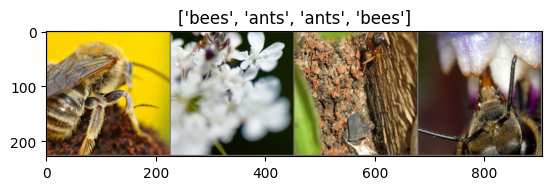

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/nu9ve/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 6.77MB/s]


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6097 Acc: 0.6680
val Loss: 0.2335 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5909 Acc: 0.7500
val Loss: 0.2134 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4510 Acc: 0.8238
val Loss: 0.1710 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4150 Acc: 0.8730
val Loss: 0.6281 Acc: 0.7582

Epoch 4/24
----------
train Loss: 0.5573 Acc: 0.8033
val Loss: 0.3568 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.6430 Acc: 0.7787
val Loss: 0.2511 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5553 Acc: 0.8320
val Loss: 0.2702 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.5316 Acc: 0.7787
val Loss: 0.2140 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4421 Acc: 0.8279
val Loss: 0.2329 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.1951 Acc: 0.9344
val Loss: 0.2060 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2615 Acc: 0.9221
val Loss: 0.2535 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2954 Acc: 0.8689
val Loss: 0.2019 Acc: 0.9346

Ep

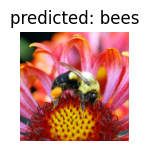

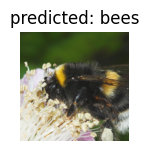

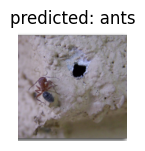

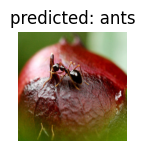

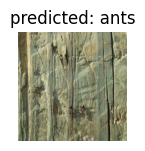

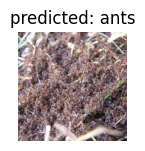

In [10]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5928 Acc: 0.6926
val Loss: 0.2504 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6708 Acc: 0.7172
val Loss: 0.1826 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5375 Acc: 0.7869
val Loss: 0.1911 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4451 Acc: 0.7869
val Loss: 0.2544 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5828 Acc: 0.7541
val Loss: 0.2078 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4244 Acc: 0.8156
val Loss: 0.1974 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3424 Acc: 0.8320
val Loss: 0.1969 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3031 Acc: 0.8770
val Loss: 0.1970 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3151 Acc: 0.8689
val Loss: 0.2442 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2150 Acc: 0.9180
val Loss: 0.2089 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3612 Acc: 0.8566
val Loss: 0.1931 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3306 Acc: 0.8566
val Loss: 0.2035 Acc: 0.9412

Ep

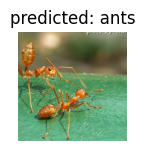

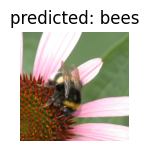

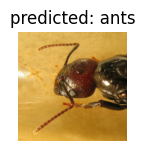

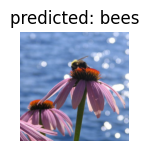

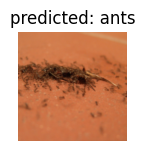

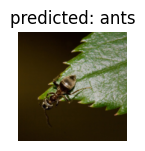

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [14]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

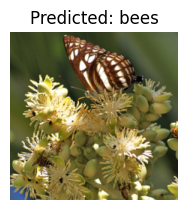

In [17]:
visualize_model_predictions(
    model_conv,
    img_path='../../../../data/transfer/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## fashion mnist

In [20]:


# Define Dataset class
class FashionistaDataset(datasets.FashionMNIST):
    def __init__(self, root='./', labels=None, transform=None, train=True, data=None, download=False, targets=''):
        super().__init__(root, transform=transform, download=download, train=train)
        if data is not None:
            self.data = data
        if targets is not '':
            self.targets = targets
        # self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        # self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        # print(self.data[index].shape)
        # Fetch the image
        if type(self.data[index]) == torch.Tensor:
            img = self.data[index].reshape(28, 28).numpy().astype('uint8')
        else:
            img = self.data[index].reshape(28, 28).astype('uint8')
        # print("type of img: ", type(img))
        # print(img.shape)

        # Convert to PIL Image for consistency
        img = Image.fromarray(img, mode="L")
        # img = Image.fromarray(img.numpy(), mode="L")

        # Apply transformations to the image
        if self.transform is not None:
            img = self.transform(img)

        # print(self.targets)
        # If targets exist, process and return them; otherwise, return only the image
        if self.targets is not None:
            target = int(self.targets[index])  # Convert target to int
            if self.target_transform is not None:
                target = self.target_transform(target)
            return img, target
        else:
            return img  # No label for test data

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_83227/1539427790.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if targets is not '':


In [51]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../../../data/kaggle/'
# dataset = FashionistaDataset(root = data_dir, download=False)
# fashion_data = FashionistaDataset(root = data_dir, train = True, transform = train_transform)
# fashion_val_data = FashionistaDataset(root = data_dir, train = False, transform = val_transform)
image_datasets = {
    'train': FashionistaDataset(root = data_dir, download=False, train=True, transform=data_transforms['train']),
    'val': FashionistaDataset(root = data_dir, download=False, train=False, transform=data_transforms['val'])
}



data_indices = list(range(len(image_datasets['train'])))
labels = [image_datasets['train'][i][1] for i in data_indices]  # Assuming image_datasets['train'][i] returns (image, label)

# Perform train-test split
train_indices, val_indices = train_test_split(
    data_indices, 
    test_size=10000 / len(image_datasets['train']),  # Equivalent to 10k validation samples from 60k
    random_state=9,  # For reproducibility
    stratify=labels  # Ensures balanced class distribution
)

# Create Subsets for train and validation datasets
train_data = Subset(image_datasets['train'], train_indices)
validation_data = Subset(image_datasets['train'], val_indices)
#   x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        #   data_transforms[x])
                #   for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

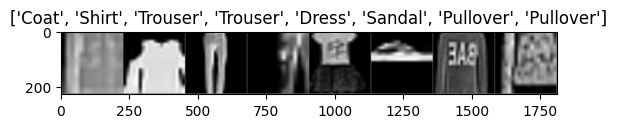

In [52]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [53]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [54]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7812 Acc: 0.7227
val Loss: 0.3097 Acc: 0.8905

Epoch 1/24
----------
train Loss: 0.5868 Acc: 0.7917
val Loss: 0.3291 Acc: 0.8894

Epoch 2/24
----------
train Loss: 0.5278 Acc: 0.8125
val Loss: 0.2785 Acc: 0.9014

Epoch 3/24
----------
train Loss: 0.4945 Acc: 0.8227
val Loss: 0.2558 Acc: 0.9112

Epoch 4/24
----------
train Loss: 0.4727 Acc: 0.8309
val Loss: 0.2319 Acc: 0.9171

Epoch 5/24
----------
train Loss: 0.4551 Acc: 0.8379
val Loss: 0.2181 Acc: 0.9230

Epoch 6/24
----------
train Loss: 0.4374 Acc: 0.8428
val Loss: 0.2169 Acc: 0.9211

Epoch 7/24
----------
train Loss: 0.3758 Acc: 0.8649
val Loss: 0.1847 Acc: 0.9331

Epoch 8/24
----------
train Loss: 0.3573 Acc: 0.8705
val Loss: 0.1767 Acc: 0.9361

Epoch 9/24
----------
train Loss: 0.3538 Acc: 0.8736
val Loss: 0.1737 Acc: 0.9375

Epoch 10/24
----------
train Loss: 0.3520 Acc: 0.8740
val Loss: 0.1751 Acc: 0.9350

Epoch 11/24
----------
train Loss: 0.3401 Acc: 0.8774
val Loss: 0.1705 Acc: 0.9398

Ep

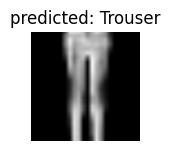

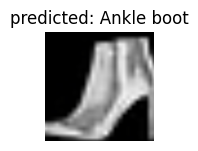

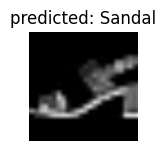

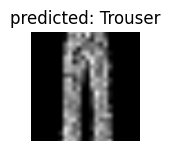

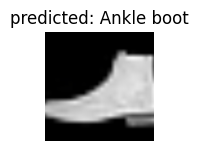

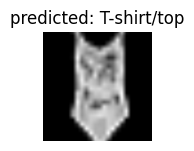

In [55]:
# visualize model for fashion mnist dataset
visualize_model(model_ft)

# visualize_model_predictions(
#     model_conv,
#     img_path='../../../../data/transfer/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
# )

plt.ioff()
plt.show()

In [ ]:
val_loader = dataloaders['val']
train_loader = dataloaders['train']
train_loss = 0

def get_model_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# current model validation accuracy
model_ft.eval()
val_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_ft(X_batch)
        loss = criterion(outputs, y_batch)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

val_loss /= len(val_loader)
train_loss /= len(train_loader)
val_accuracy = correct / total
val_accuracy, val_loss


accs = get_model_accuracy(model_ft, val_loader)

In [58]:
accs

0.941

In [60]:
# save model
torch.save(model_ft.state_dict(), 'fashion_resnet_model.pth')